### El proyecto consta de dos partes fundamentales, una clase "Star" que tiene las caracteristicas principales de una estrella, y la otra es la clase "Observer", en donde se agrupan las funciones que va a poder hacer un observador tanto independientemente como con las estrellas

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt

Datos obtenidos de: https://github.com/astronexus/HYG-Database

In [104]:
hyg = pd.read_csv("hygdata_v3.csv")

### Explicacion de las columnas utilizadas

En astronomia las estrellas tienen varios identificadores y catalogos que las agrupan, vamos a usar el catalogo Hipparco (__Hip__) y el Henry Draper (__Hd__). Algunas estrellas han tenido un significado especial para la ciencia o la historia por lo que han sido reconocidas frecuentemente con algun nombre propio como es el caso del sol, sirio, entre otras (__proper__). El cielo se separa en diferentes formas que han tenido tambien cierto caracter historico, como lo son las constelaciones del zodiaco, sin embargo para agrupar todas las estrellas de este modo, no se crean formas, sino zonas de la esfera celeste que agrupan a las estrellas dentro de estas bajo una sola constelacion, en total hay 88, con su respectiva ubicacion, nombre y sufijo (__con__)

Las estrellas usan dos coordenadas universales, la ascension recta y la declinacion.

La ascensión recta se mide a partir del punto Aries en horas hacia el Este a lo largo de la linea marcada por el ecuador en la esfera celeste, se mide entre $0h<\alpha<24h$ o $0°<\alpha<360°$ (__ra__)
Mientras que la declinacion es el angulo que forma una estrella desde el ecuador celeste, siendo positivo hacia el polo norte y negativo hacia el polo sur, se mide entre $0°<\delta<360°$ (__dec__)
Estas coordenadas se mueven debido a que estas estrellas tienen movimiento individual en la galaxia. Este movimiento propio se mide en miliarcosegundos por año (mas/year), y hay uno correspondiente a la ascension recta (__pmra__) y otro a la declinacion (__pmdec__).

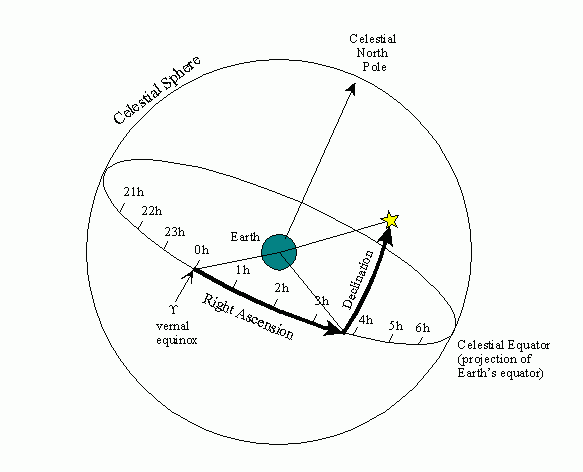

Junto con este movimiento las estrellas se mueven en direccion de la linea de vision del observador, este movimiento es conocido como movimiento radial (__rv__) y es medido en km/seg, si el movimiento es positivo, la estrella se esta alejando y negativo si se esta acercando.

El paralaje es el angulo creado por observar un objeto desde distintos puntos de vista. De manera mas especifica, en astronomia es el angulo creado por la estrella debido al movimiento de la tierra alrededor del sol, como se ve en la figura.
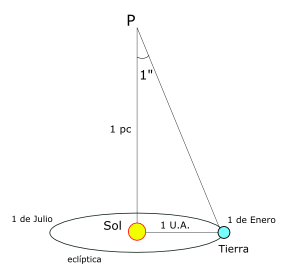
Para medir distancias (__dist__), en el espacio se usa el parsec que es la distancia de una estrella al sol, con un paralaje de un segundo de arco , son aproximadamente 3.26 años luz

Las estrellas tienen un brillo natural, sin embargo el ojo no puede percibir todas las estrellas debido a la lejania de estas ademas de su "intensidad". Por lo que se creo una clasificacion del brillo llamada magnitud, mientras menor sea la magnitud, mas brillante es una estrella en el cielo, la magnitud maxima visible por el ojo humano es de $\approx6.5$. 

Sin embargo esta magnitud es la vista por un observador en la tierra y esta afectada por el factor de la distancia, por lo que esta magnitud vista se llama magnitud aparente (__mag__), mientras que la magnitud absoluta (__absmag__) es la magnitud aparente que tendria una estrella si estuviera a $10$ parsecs de distancia 

Finalmente la luminosidad, medida en watts, es la potencia emitida por una estrella en todas las direcciones, y su medida es bastante alta, la luminosidad del sol por ejemplo es $3.827*10^{26}$, por lo que en astronomia la luminosidad se mide en luminosidades solares (__lum__)


In [105]:
hyg = hyg[['hip', 'hd','proper', 'ra', 'dec', 'dist',
       'pmra', 'pmdec', 'rv', 'mag', 'absmag', 'con', 'lum']][1:]
hyg["ra"] = hyg["ra"]*15
hyg = hyg[(hyg["hip"].notna()) & (hyg["hd"].notna())]
hyg["proper"].fillna(hyg["hip"],inplace = True)
hyg = hyg.reset_index()

##### Se asignan los atributos a la clase y se crean diferentes funciones
- Minimum_dist: Permite hallar la distancia minima a la que se encontrara una estrella, y el tiempo en que llegara a este punto minimo. En esta funcion la resolucion de problemas fisicos de cinematica 
- Constellation: Crea un grafico de la constelacion dada, para las graficaciones se uso una projeccion azimutal equidistante

Constructores
- from_hip: Obtiene una instancia de la clase Star a partir de su identificador HIP
- from_hd: Obtiene una instancia de la clase Star a partir de su identificador HD
Sobreescritura
- iter: Se permite que la clase pueda ser recorrida como una lista, dando las estrellas
- repr: Cambia la forma en que las instancias son vistas en listas, dataframes y otros
- str: Modifica el modo en que se muestra la instancia cuando se usa la funcion print y otras


In [173]:
class Star:
    num_stars = 0
    catalog = []
    def __init__(self,hip,hd,proper,ra,dec,dist,pmra,pmdec,rv,mag,absmag,con,lum):
        self.hip = hip
        self.hd = hd
        self.name = proper
        self.ra = ra
        self.dec = dec
        self.distance = dist
        self.proper_motion =[pmra,pmdec]
        self.total_proper_motion = np.sqrt((pmra*np.cos(np.deg2rad(dec)))**2+pmdec**2)
        self.radial_motion = rv
        self.magnitude = mag
        self.abs_magnitude = absmag
        self.constellation = con
        self.luminosity = lum
        Star.num_stars +=1
        Star.catalog.append(self)
        
    def minimum_dist(self):
        """
        Calculo de la distancia minima de una estrella a el sol y
        el tiempo que demorara en alcanzar este punto
        """
        vr = self.radial_motion # Velocidad radial en km/s
        r = self.distance*3.08567758128e+13  # Distancia en km
        mu =self.total_proper_motion*np.pi/(3600*180*31536000*1000)
        vtheta = r*mu   # Velocidad transversal
        alpha = np.arctan(vtheta/vr) # Hallamos el angulo alpha
        distance_min = r*np.sin(alpha)*3.2407793877921e-14 # Calculo de la distancia minima en parsec
        v = np.sqrt(vtheta**2+vr**2) # Velocidad en direccion de la trayectoria
        trayectory = r*np.cos(alpha) # Distancia recorrida por la estrella
        t =  (trayectory/v)
        final_t = t/(60*60*24*365) # Tiempo que toma en recorrer esa distancia en años
    
        return {"distance ( parsec ) ":distance_min,"time ( year )":final_t}
    
    @staticmethod
    def __x_y(star,center):
        
        dec = np.deg2rad(star.dec)
        alpha = np.deg2rad(star.ra)
        alpha_0 = np.deg2rad(center[0]*15)
        dec_0 = np.deg2rad(center[1])
        delta_ra = alpha - alpha_0
        x1 = np.cos( dec) * np.sin( delta_ra);
        y1 = np.sin( dec) * np.cos( dec_0) - np.cos( dec) * np.cos( delta_ra) * np.sin( dec_0)
        z1 = np.sin( dec) * np.sin( dec_0) + np.cos( dec) * np.cos( dec_0) * np.cos( delta_ra)
        if z1 < -.9:
            d = 20. * np.sqrt(( 1. - .81) / ( 1.00001 - z1**2))
        else:
            d = 2. / (z1 + 1.)    
        x = x1 * d
        y = y1 * d
        return x,y
    
    @staticmethod
    def constellation(sufix):
        """Graficacion de las estrellas mas importantes (magnitud <4 ) dentro de una
        constelacion"""
        stars_in_con = []
        for st in Star.catalog[:-2]:
            if isinstance(st.constellation,float):
                continue
            if st.constellation.upper() == sufix.upper(): # Filtro de constelacion
                if st.magnitude < 4: # Filtro de magnitud
                    stars_in_con.append(st)
        number = len(stars_in_con)
        if number == 0:
            raise NameError("Wrong Suffix") # Se arroja cuando un sufijo no existe
        sumra = 0
        sumdec = 0
        for i in range(number):
            sumra += stars_in_con[i].ra #Promedio de ascension recta, usado para el punto central del grafico
            sumdec += stars_in_con[i].dec # Promedio de declinacion, usado para el punto central del grafico
        center = [sumra/number,sumdec/number]
        plt.figure(figsize = (10,10))
        for i in range(number):
            xy = Star.__x_y(stars_in_con[i],center) # Puntos x,y desde la ascension y declinacion
            mag = stars_in_con[i].magnitude # Magnitud de la estrella
            # Se grafica y se modifica la escala de magnitud para ser coherente con la vision real
            plt.plot(-xy[0],xy[1],"wo",markersize = 4*(1-mag/5))
            plt.text(-xy[0],xy[1],stars_in_con[i].name)
        plt.style.use("dark_background")
        plt.axis('off')
            
    @classmethod
    def from_hip(self,hip):
        star_hip = [st for st in Star.catalog if st.hip == hip]
        if len(star_hip) == 0:
            raise NameError
        return star_hip[0]
    @classmethod
    def from_hd(self,hd):
        star_hd = [st for st in Star.catalog if st.hd == hd]
        if len(star_hd) == 0:
            raise NameError
        return star_hd[0]
        
    def __iter__(self):
        return self.catalog
    def __repr__(self):
        return str(self.name)
    def __str__(self): # common special method to print
        names = ["hip","hd","name","ra","dec","distance","proper_motion",
                  "total_proper_motion","radial_motion","magnitude",
                 "abs_magnitude","constellation","luminosity"]
        values = [self.hip,self.hd,self.name,self.ra,
                  self.dec,self.distance,self.proper_motion,
                  self.total_proper_motion,self.radial_motion,
                  self.magnitude,self.abs_magnitude,self.constellation,
                  self.luminosity]
        return str(dict(zip(names,values)))


Se asigna a cada uno de los valores del dataframe una instancia de la clase Star

In [174]:
def creation_stars(data):
    new_star =Star(data["hip"],data["hd"],data["proper"],data["ra"],data["dec"],
         data["dist"],data["pmra"],data["pmdec"],data["rv"],data["mag"],
         data["absmag"],data["con"],data["lum"])
    return new_star
collection_stars = hyg.apply(creation_stars,axis=1)

#### Como ejemplo de la distancia minima de una estrella, se calcula la distancia minima y el tiempo de Aldebaran

In [228]:
Aldebaran = Star.from_hip(21421)
dist, time = list(Aldebaran.minimum_dist().values())
print("La distancia actual de Aldebaran es de {} parsecs".format(round(Aldebaran.distance,2)))
print("La distancia minima que alcanzara Aldebaran al sol es de {} parsecs".format(round(dist,3)))
print("El tiempo en alcanzarla sera de {} años".format(round(time,2)))

La distancia actual de Aldebaran es de 20.43 parsecs
La distancia minima que alcanzara Aldebaran al sol es de 6.808 parsecs
El tiempo en alcanzarla sera de 326119.77 años


##### Como ejemplo de la funcion constellation se muestra la constelacion de Orion,  con su representativo cinturon y las estrellas mas importantes. Recordar que la constelacion no es la figura si no la seccion de la esfera celeste

<IPython.core.display.Javascript object>


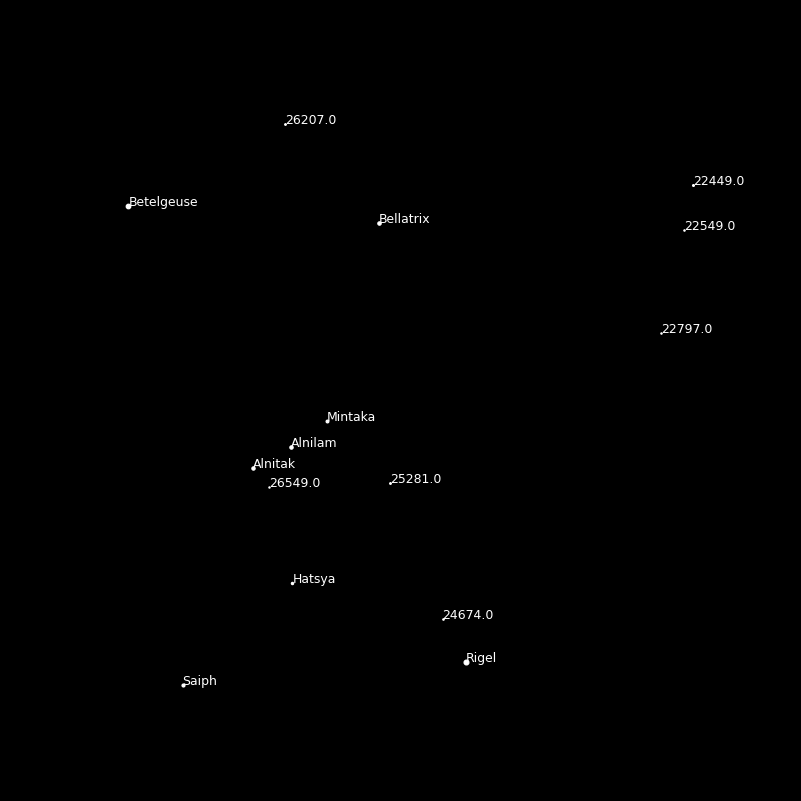

In [175]:
Star.constellation("Ori")

#### La clase Observer tiene la posicion y fecha de un observador.
##### Funciones 
- fj_function: Calcula la fecha juliana en la que esta el observador, es un punto necesario de referencia para muchos calculos astronomicos
- tsl: El punto $0$ de las coordenadas ecuatoriales absolutas, que son las utilizadas, es el punto vernal. La fecha juliana es el angulo horario en el que se ubica el punto vernal en el momento
- rise: Calculo de la hora de salida de una estrella
- set_: Calculo de la hora de puesta de una estrella
- transit: Calculo de la hora de transito (maxima altura) de una estrella
- celestial_chart: Graficacion de las estrellas que van a ser visibles en este momento del dia

##### Funciones privadas
- __hour_angle_ps: Se obtiene el angulo horario del momento de salida y puesta,dado para una estrella.
- __local_hour: Paso del angulo horario a la hora reloj del observador. Esta funcion es utilizada para la funcion rise, set y transit
- __x_y: Obtencion de las coordenadas x, y para la graficacion de las estrellas, utilizada en celestial_chart

In [194]:
class Observer:
    j2000 = 2451545

    def __init__(self, longitude, latitude,gmt, year=0, month=0, day=0, hour=0, minute=0, second=0):
        self.longitude = longitude
        self.latitude = latitude
        self.gmt = gmt
        if year != 0:      
            self.year = year
            self.month = month
            self.day = day
            self.hour = hour
            self.minute = minute
            self.second = second
        else:
            time = pd.to_datetime("now")
            self.year = time.year
            self.month = time.month
            self.day = day
            self.hour = hour
            self.minute = time.minute
            self.second = time.second

    
    def fj_function(self):
        t0 = pd.to_datetime("2000-01-01 12:00")
        date = "{}-{}-{} {}:{}:{}".format(self.year, self.month,
                                          self.day, self.hour, self.minute, self.second)
        t1 = pd.to_datetime(date)
        dt = (t1 - t0).total_seconds() / 3600 / 24
        fj = Observer.j2000 + dt if self.year > 0 else Observer.j2000 - dt
        return fj

    
    def tsl(self):
        fj = Observer.fj_function(self)
        t = (fj - Observer.j2000) / 36525
        tsg0 = (24110.54841 + t * 8640148.812866 + (t ** 2) * 0.093104) / 3600
        tsg0 = tsg0 - mt.floor(tsg0 / 24) * 24
        utc = self.hour + self.minute / 60 + self.second / 3600 - self.gmt
        tsg_t = tsg0 + utc * 1.00274
        tsl_final = tsg_t + self.longitude / 15
        return tsl_final - mt.floor(tsl_final / 24) * 24

    
    def __hour_angle_ps(self,star):
        """
        Funcion que halla el angulo horario al que sale una estrella teniendo la declinacion, latitud
        """
        dec = np.deg2rad(star.dec)
        lat = np.deg2rad(self.latitude)
        value = - np.tan(dec) * np.tan(lat)
        if value > 1:
            print("La estrella es circumpolar o no sale por el horizonte")
            return -1
        value = np.rad2deg(np.arccos(value))
        # Puesta, Salida
        if value / 15 < 12:
            return [value / 15, (360 - value) / 15]
        else:
            return [(360 - value) / 15, value / 15]

    
    def __local_hour(self, star, hour_angle):
        """
        Funcion que halla la hora de salida y puesta de un astro para un lugar especifico
        @return: Angulo horario de la estrella
        """
        tsl_s = star.ra / 15 + hour_angle
        tsl_s = tsl_s - mt.floor(tsl_s / 24) * 24
        tsg_ts = tsl_s - self.longitude / 15
        tsg_ts = tsg_ts - mt.floor(tsg_ts / 24) * 24
        fj = Observer.fj_function(self)
        t = (fj - Observer.j2000) / 36525
        tsg0 = (24110.54841 + t * 8640184.812866 + (t ** 2) * 0.093104 - 0.0000062 * (t ** 3)) / 3600
        tsg0 = tsg0 - mt.floor(tsg0 / 24) * 24
        utc = (tsg_ts - tsg0) / 1.00274
        utc = utc - mt.floor(utc / 24) * 24
        local_time = utc + self.gmt
        return local_time - mt.floor(local_time / 24) * 24
    
    
    def rise(self, star):
        hour_angle_rise = Observer.__hour_angle_ps(self, star)[1]
        local_rise = Observer.__local_hour(self, star, hour_angle_rise)
        return local_rise
    
    def set_(self, star):
        hour_angle_rise = Observer.__hour_angle_ps(self, star)[0]
        local_set = Observer.__local_hour(self, star, hour_angle_rise)
        return local_set

    def transit(self, star):
        local_transit = Observer.__local_hour(self, star, 0)
        return local_transit
    
    def __x_y(self,star,tsl):
        dec = np.deg2rad(star.dec)
        alpha = np.deg2rad(star.ra)
        alpha_0 = np.deg2rad(tsl*15)
        dec_0 = np.deg2rad(self.latitude)
        delta_ra = alpha - alpha_0
        x1 = np.cos( dec) * np.sin( delta_ra);
        y1 = np.sin( dec) * np.cos( dec_0) - np.cos( dec) * np.cos( delta_ra) * np.sin( dec_0)
        z1 = np.sin( dec) * np.sin( dec_0) + np.cos( dec) * np.cos( dec_0) * np.cos( delta_ra)
        if z1 < -.9:
            d = 20. * np.sqrt(( 1. - .81) / ( 1.00001 - z1**2))
        else:
            d = 2. / (z1 + 1.)    
        x = x1 * d
        y = y1 * d
        return x,y
    def celestial_chart(self):
        if self.latitude > 0: # Filtro de ubicacion, es decir, que la estrella pueda ser vista en ese lugar
            stars_in_zone = [st for st in Star.catalog if st.dec > self.latitude - 90]
        else:
            stars_in_zone = [st for st in Star.catalog if st.dec < self.latitude + 90]
        tsl = self.tsl()
        stars_in_time = []
        for st in stars_in_zone: # Filtro de si la estrella puede ser vista en ese momento del observador
            H = tsl-st.ra/15 if tsl-st.ra/15 > 0 else 24 + tsl-st.ra/15
            if (H < 6) or (H > 18):   
                if st.magnitude < 2.9: # Filtro de magnitud, para mostrar solo algunas de las mas brillantes
                    stars_in_time.append(st)
        plt.figure(figsize = (10,10))
        for i in range(len(stars_in_time)):
            xy = self.__x_y(stars_in_time[i],tsl)
            name = stars_in_time[i].name
            mag = stars_in_time[i].magnitude
            plt.plot(-xy[0],xy[1],"wo",markersize = 4*(1-mag/4))
            plt.text(-xy[0],xy[1],name)
        plt.style.use("dark_background")
        plt.axis('off')

##### Como ejemplo se ubica un observador en Bogota y se grafica el cielo del dia 28 de Octubre a las 00:00 

In [197]:
me = Observer(-74.081,4.6097,-5,2021,10,28)

<IPython.core.display.Javascript object>


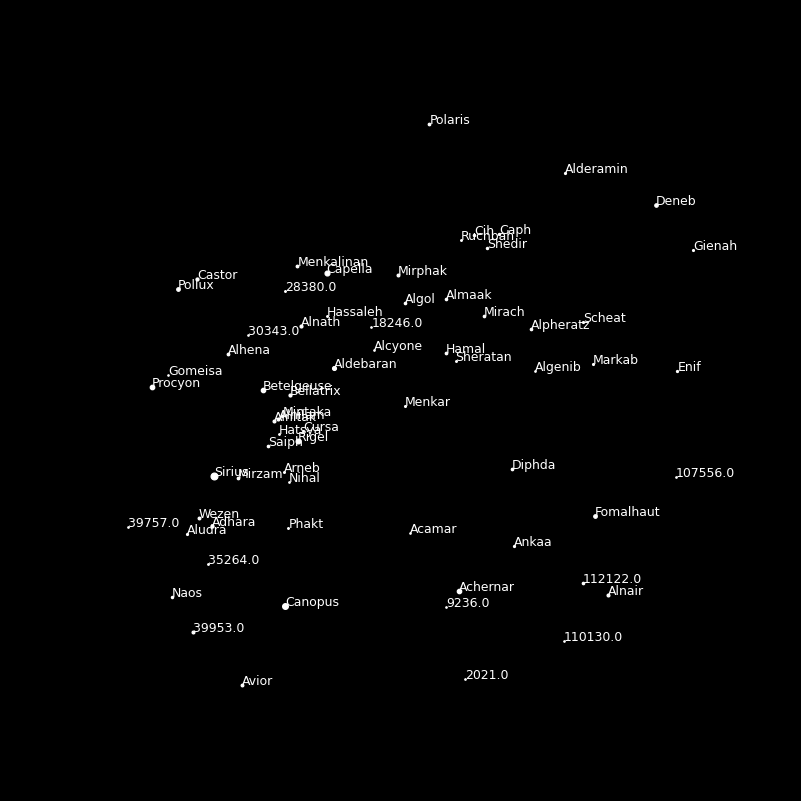

In [198]:
%matplotlib notebook
a = me.celestial_chart()

#### Se usa la estrella Aldebaran, asignandola por su HIP (21421) para calcular los tiempos de salida, puesta y transito

In [212]:
Hour_rise = me.rise(Aldebaran)
Hour_set = me.set_(Aldebaran)
Hour_transit = me.transit(Aldebaran)
print("La hora de salida de Aldebaran es:", round(Hour_rise,2))
print("La hora de puesta de Aldebaran es:", round(Hour_set,2))
print("La hora de transito de Aldebaran es:", round(Hour_transit,2))
if Hour_set < Hour_rise:
    total_time = Hour_set+24-Hour_rise
else:
    total_time = Hour_Set-Hour_rise

print("Aldebaran va a estar en el cielo visible durante {} horas, y el momento de mas altura sera a las {}".format(round(total_time,2),
                                                                                                           round(Hour_transit,2)))

La hora de salida de Aldebaran es: 20.01
La hora de puesta de Aldebaran es: 8.16
La hora de transito de Aldebaran es: 2.08
Aldebaran va a estar en el cielo visible durante 12.15 horas, y el momento de mas altura sera a las 2.08
